In [1]:
# add modules to Python's search path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import numpy as np
import matplotlib.pyplot as plt

#import  torch
#from geomloss import SamplesLoss
import tensorflow as tf
from modules import wasserstein as tfw
import tensorflow_probability as tfp
import scipy as sp
from sklearn import preprocessing

In [2]:
"""
use_cuda = torch.cuda.is_available()
# N.B.: We use float64 numbers to get nice limits when blur -> +infinity
dtype    = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor

# make a convenient wrapper for producing samples in form of a tensor
def torch_sampler(mean, cov, size):
    samples = np.random.multivariate_normal(mean, cov, size)
    return torch.from_numpy(samples)

# set up parameters for our two test distributions
dimension = 3
mean_1 = np.zeros(dimension)
mean_2 = mean_1 + 0.1 * np.ones(dimension)
cov_1 = np.identity(dimension)
cov_2 = cov_1

# finally create the samplers our test distributions
sampler_1 = lambda size: torch_sampler(mean_1, cov_1, size)
sampler_2 = lambda size: torch_sampler(mean_2, cov_2, size)

# test our samplers
print("samples from distribution #1:\n{}".format(sampler_1(3)))
print("samples from distribution #2:\n{}".format(sampler_2(3)))
"""

'\nuse_cuda = torch.cuda.is_available()\n# N.B.: We use float64 numbers to get nice limits when blur -> +infinity\ndtype    = torch.cuda.DoubleTensor if use_cuda else torch.DoubleTensor\n\n# make a convenient wrapper for producing samples in form of a tensor\ndef torch_sampler(mean, cov, size):\n    samples = np.random.multivariate_normal(mean, cov, size)\n    return torch.from_numpy(samples)\n\n# set up parameters for our two test distributions\ndimension = 3\nmean_1 = np.zeros(dimension)\nmean_2 = mean_1 + 0.1 * np.ones(dimension)\ncov_1 = np.identity(dimension)\ncov_2 = cov_1\n\n# finally create the samplers our test distributions\nsampler_1 = lambda size: torch_sampler(mean_1, cov_1, size)\nsampler_2 = lambda size: torch_sampler(mean_2, cov_2, size)\n\n# test our samplers\nprint("samples from distribution #1:\n{}".format(sampler_1(3)))\nprint("samples from distribution #2:\n{}".format(sampler_2(3)))\n'

In [3]:
"""
num_samples_1 = 500
num_samples_2 = 500
samples_1 = sampler_1(num_samples_1)
samples_2 = sampler_2(num_samples_2)
loss = SamplesLoss("sinkhorn", p=2, blur=0.01, scaling=.99, backend="online")
print(np.sqrt(loss(samples_1, samples_2).item()))
"""

'\nnum_samples_1 = 500\nnum_samples_2 = 500\nsamples_1 = sampler_1(num_samples_1)\nsamples_2 = sampler_2(num_samples_2)\nloss = SamplesLoss("sinkhorn", p=2, blur=0.01, scaling=.99, backend="online")\nprint(np.sqrt(loss(samples_1, samples_2).item()))\n'

In [18]:
# make a convenient wrapper for producing samples in form of a tensor
def tf_sampler(mean, cov, size):
    samples = np.random.multivariate_normal(mean, cov, size)
    return tf.convert_to_tensor(samples, dtype=tf.float32)

# set up parameters for our two test distributions
dimension = 5
mean_1 = np.zeros(dimension)
mean_2 = mean_1 + 0.0 
cov_1 = 1.0 * np.identity(dimension)
cov_2 = 1. * cov_1

# finally create the samplers our test distributions
sampler_1 = lambda size: tf_sampler(mean_1, cov_1, size)
sampler_2 = lambda size: tf_sampler(mean_2, cov_2, size)

# test our samplers
#print("samples from distribution #1:\n{}".format(sampler_1(3)))
#print("samples from distribution #2:\n{}".format(sampler_2(3)))

# Wasserstein_2 formula
def w2_formula(ensemble_1, ensemble_2, tf=True):
    if tf:
        ensemble_1 = ensemble_1.numpy()
        ensemble_2 = ensemble_2.numpy()
    m1 = np.mean(ensemble_1, axis=0)
    m2 = np.mean(ensemble_2, axis=0)
    C1 = np.cov(ensemble_1.T)
    C2 = np.cov(ensemble_2.T)
    r_C2 = sp.linalg.sqrtm(C2)
    term_1 = np.linalg.norm(m1 - m2, ord=2)
    term_2 = np.trace( C1 + C2 - 2.0 * sp.linalg.sqrtm(np.linalg.multi_dot([r_C2, C1, r_C2])) )
    return np.sqrt(term_1**2 + term_2**2)

def exact_w2(m1, m2, C1, C2):
    term_1 = np.linalg.norm(m1 - m2, ord=2)
    r_C2 = sp.linalg.sqrtm(C2)
    term_2 = np.trace( C1 + C2 - 2.0 * sp.linalg.sqrtm(np.linalg.multi_dot([r_C2, C1, r_C2])) )
    return np.sqrt(term_1**2 + term_2**2)

In [20]:
num_samples_1 = 2000
num_samples_2 = 2000
samples_1 = sampler_1(num_samples_1)
samples_2 = sampler_2(num_samples_2)
#print(np.mean(samples_1, axis=0))
#print(np.mean(samples_2, axis=0))
loss = tfw.sinkhorn_loss(samples_1, samples_2, epsilon=0.01, num_iters=50, p=2)
loss_S = tfw.sinkhorn_div(samples_2, samples_1, epsilon=0.1, num_iters=50, p=2)
print("Wasserstein_2, computed with Sinkhorn algorithm: {}".format(np.sqrt(loss)))
print("Wasserstein_2, computed with formula: {}".format(exact_w2(mean_1, mean_2, cov_1, cov_2)))
print("Wasserstein_2, computed with Sinkhorn algorithm: {}".format(np.sqrt(loss_S)))

Wasserstein_2, computed with Sinkhorn algorithm: 0.7612422704696655
Wasserstein_2, computed with formula: 0.0
Wasserstein_2, computed with Sinkhorn algorithm: 0.7869690656661987


61.21308337771004ion #0
63.65288704911929
55.18977025188851ion #1
60.97851891293679
53.871060851606295on #2
56.28064881218007
62.91956113263058ion #3
49.25666054874831
58.01191433420417ion #4
49.72419829436401
56.63540741050371ion #5
50.12857263794434
65.45298595744013ion #6
63.093220287005465
55.56635887941306ion #7
61.03778055202015
56.82311714004696ion #8
60.73557129684315
52.09695787608822ion #9
64.29578565722845
60.24375783774974ion #10
46.91571138785167
59.94253926252081ion #11
64.95313059143788
55.01241919718278ion #12
60.46799846056333
65.28467734394468ion #13
62.92972595770727
56.906243037153274on #14
63.70167461425046
59.22558420955864ion #15
49.219587079874614
60.534732773705194on #16
56.17959579452661
54.77954655221756ion #17
64.74856400029158
57.39998251823479ion #18
63.351051565978395
56.22858609031845ion #19
52.84711083322167
59.644134698426505on #20
59.5423329822403
62.95824988256308ion #21
62.30444863364514
66.93097753246262ion #22
46.29060934024443
54.43491376625029io

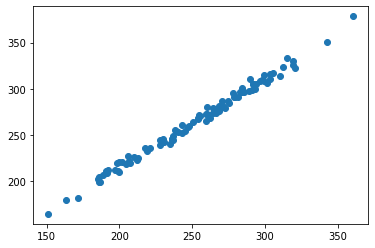

In [10]:
def generate_sampler(dim=10, mean_a=-100., mean_b=100., cov_a=-1., cov_b=1.):
    A = np.random.uniform(cov_a, cov_b, size=(dim, dim))
    cov = np.dot(A.T, A)
    print(np.linalg.norm(cov))
    mean = np.random.uniform(mean_a, mean_b, size=dim)
    return mean, cov, lambda size: tf_sampler(mean, cov, size)


num_exps = 100
dim = 10
num_samples = 100
cov_a = -2.
cov_b = -cov_a
w_s = np.zeros(num_exps)
w_f = np.zeros(num_exps)
for i in range(num_exps):
    print('Working on iteration #{}'.format(i), end='\r')
    mean_1, cov_1, sampler_1 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    mean_2, cov_2, sampler_2 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    samples_1 = sampler_1(num_samples)
    samples_2 = sampler_2(num_samples)
    w_s[i] = np.sqrt(tfw.sinkhorn_loss(samples_1, samples_2, epsilon=0.01, num_iters=50, p=2))
    w_f[i] = exact_w2(mean_1, mean_2, cov_1, cov_2) 

plt.scatter(w_s, w_f)
plt.show()

In [30]:
# Triangle inequality

num_exps = 100
dim = 10
num_samples = 200
tri = np.zeros(num_exps)
cov_a = -10.
cov_b = -cov_a
for i in range(num_exps):
    print('Working on iteration #{}'.format(i), end='\r')
    mean_1, cov_1, sampler_1 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    mean_2, cov_2, sampler_2 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    mean_3, cov_3, sampler_3 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    samples_1 = sampler_1(num_samples)
    samples_2 = sampler_2(num_samples)
    samples_3 = sampler_3(num_samples)
    w_12 = np.sqrt(tfw.sinkhorn_loss(samples_1, samples_2, epsilon=0.01, num_iters=50, p=2))
    w_23 = np.sqrt(tfw.sinkhorn_loss(samples_2, samples_3, epsilon=0.01, num_iters=50, p=2))
    w_13 = np.sqrt(tfw.sinkhorn_loss(samples_1, samples_3, epsilon=0.01, num_iters=50, p=2))
    if w_12 + w_23 >= w_13:
        tri[i] = 1.0
print('\nNumber of failures = {}'.format(num_exps - int(tri.sum())))

Working on iteration #99
Number of failures = 0


In [42]:
# Symmetry

num_exps = 100
dim = 10
num_samples = 200
sym = np.zeros(num_exps)
cov_a = -1.
cov_b = -cov_a
for i in range(num_exps):
    print('Working on iteration #{}'.format(i), end='\r')
    mean_1, cov_1, sampler_1 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    mean_2, cov_2, sampler_2 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    samples_1 = sampler_1(num_samples)
    samples_2 = sampler_2(num_samples)
    w_12 = np.sqrt(tfw.sinkhorn_loss(samples_1, samples_2, epsilon=0.01, num_iters=500, p=2))
    w_21 = np.sqrt(tfw.sinkhorn_loss(samples_2, samples_1, epsilon=0.01, num_iters=500, p=2))
    #print(w_12, w_21)
    if abs(w_12 - w_21)/w_12 < 1e-2:
        sym[i] = 1.0
print('\nNumber of failures = {}'.format(num_exps - int(sym.sum())))

15.699871458401564on #0
16.76883834455234
14.293692413219672on #1
13.407910249475403
14.011974809950193on #2
14.99734409766792
14.406216159891267on #3
13.159388423086902
15.023351516041505on #4
14.094890190470561
13.080523961228907on #5
14.420514811581596
14.983384885574157on #6
14.372005725122301
13.936690898700546on #7
15.178562934783299
18.19225591480716ion #8
12.550024926068081
13.515316445506906on #9
13.826960032823388
14.635924528570827on #10
13.884075918446788
17.74089147720352ion #11
14.8381644165007
16.12390490178295ion #12
14.146568199501809
15.340511215477584on #13
15.810464773326261
14.07431832717446ion #14
15.816751782541512
14.820147713457466on #15
14.850133701611066
14.455503220124957on #16
15.220832706465927
15.713271435812011on #17
15.056726621013256
14.733170388259419on #18
15.327659998394566
13.52367813252385ion #19
15.746484616339448
18.917464590534994on #20
14.322836887893967
14.267999406714448on #21
13.689673868239082
12.756050802488392on #22
13.11637162786462
15.

KeyboardInterrupt: 

In [26]:
# Identity

num_exps = 100
dim = 10
num_samples = 200
id_ = np.zeros(num_exps)
cov_a = -10.
cov_b = -cov_a
for i in range(num_exps):
    print('Working on iteration #{}'.format(i), end='\r')
    mean_1, cov_1, sampler_1 = generate_sampler(dim=dim, cov_a=cov_a, cov_b=cov_b)
    samples_1 = sampler_1(num_samples)
    w = np.sqrt(tfw.sinkhorn_loss(samples_1, samples_1, epsilon=0.01, num_iters=50, p=2))
    if w == 0.:
        id_[i] = 1.0
print('\nNumber of failures = {}'.format(num_exps - int(id_.sum())))

Working on iteration #99
Number of failures = 0
